# Análisis Automatizado de Algoritmos de Ordenamiento
Este notebook realiza un análisis comparativo de la complejidad de los algoritmos **Bubble Sort**, **Insertion Sort** y **Quicksort**.

Se incluye:
1. Benchmarking automatizado con múltiples intentos.
2. Cálculo de la desviación estándar.
3. Gráficas de complejidad.
4. Análisis de regresión lineal para validar la complejidad teórica.

In [14]:
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Importar los algoritmos
from sort.bubble_sort import bubble_sort
from sort.insertion_sort import insertion_sort
from sort.quicksort import quicksort

sns.set_theme(style="whitegrid")

## 1. Benchmarking Automatizado
Definimos una función para medir el tiempo de ejecución con múltiples intentos por cada tamaño de entrada ($n$).

In [15]:
def measure_time(S, sort_function):
    S_copy = S.copy()
    start_time = time.perf_counter_ns()
    sort_function(S_copy)
    end_time = time.perf_counter_ns()
    return end_time - start_time

def benchmark_algorithms(sizes, trials=10):
    results = []
    for n in sizes:
        print(f"Procesando n={n}...", end="\r")
        for _ in range(trials):
            S = [random.randint(0, n) for _ in range(n)]
            results.append({
                'n': n,
                'Bubble Sort': measure_time(S, bubble_sort),
                'Insertion Sort': measure_time(S, insertion_sort),
                'Quicksort': measure_time(S, quicksort)
            })
    print("\nBenchmarking completado.")
    return pd.DataFrame(results)

# Tamaños de entrada para el análisis
sizes = [10, 50, 100, 250, 500, 750, 1000]
df_raw = benchmark_algorithms(sizes, trials=10)

Procesando n=1000...
Benchmarking completado.


## 2. Análisis Estadístico (Promedio y Desviación Estándar)
Agrupamos los datos por $n$ para calcular el promedio y la desviación estándar.

In [16]:
df_stats = df_raw.groupby('n').agg(['mean', 'std']).reset_index()
df_stats.columns = ['n', 'bubble_mean', 'bubble_std', 'insertion_mean', 'insertion_std', 'quicksort_mean', 'quicksort_std']

df_stats

,n,bubble_mean,bubble_std,insertion_mean,insertion_std,quicksort_mean,quicksort_std
0,10,13342.5,2.456097e+03,5164.4,1692.054254,15661.6,2170.989135
1,50,240725.4,1.599783e+04,72742.2,7512.684456,115332.0,108162.389740
2,100,827261.0,6.565272e+04,215091.5,10817.833684,144106.8,8823.990604
3,250,3273332.9,8.943596e+05,894463.7,258478.046444,258501.2,76737.176537
4,500,7717487.8,3.027615e+05,1997659.8,134493.766090,306324.6,14057.881057
5,750,20670530.9,4.708544e+06,5020219.3,293750.128267,559302.3,92193.818959
6,1000,36567322.1,1.367190e+06,9501795.9,393640.821680,759049.7,31299.974455


### Gráfica de Tiempos de Ejecución con Desviación Estándar

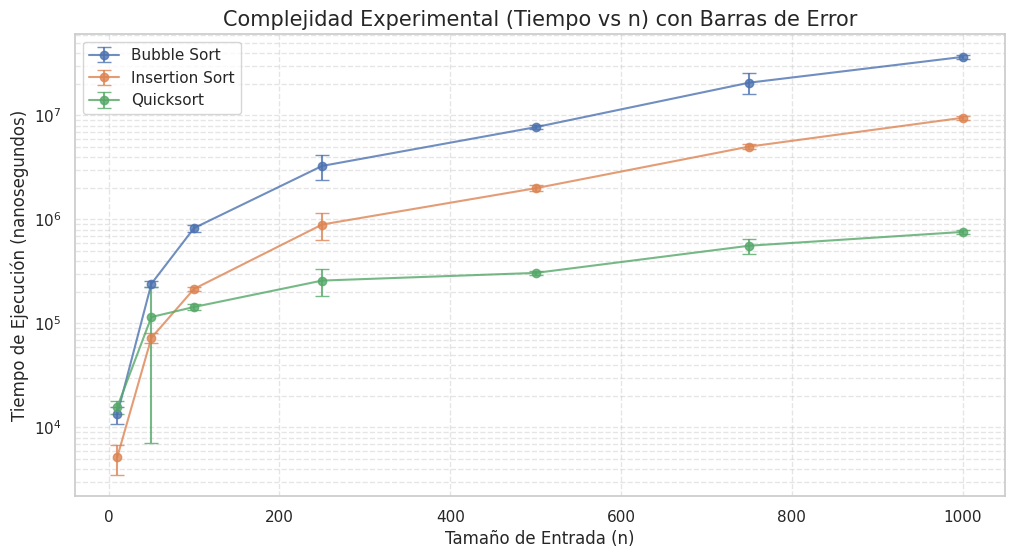

In [17]:
plt.figure(figsize=(12, 6))

for algo in ['Bubble Sort', 'Insertion Sort', 'Quicksort']:
    mean_col = algo.lower().split()[0] + '_mean'
    if algo == 'Quicksort': mean_col = 'quicksort_mean'
    std_col = algo.lower().split()[0] + '_std'
    if algo == 'Quicksort': std_col = 'quicksort_std'
    
    plt.errorbar(df_stats['n'], df_stats[mean_col], yerr=df_stats[std_col], 
                 label=algo, fmt='-o', capsize=5, alpha=0.8)

plt.title('Complejidad Experimental (Tiempo vs n) con Barras de Error', fontsize=15)
plt.xlabel('Tamaño de Entrada (n)', fontsize=12)
plt.ylabel('Tiempo de Ejecución (nanosegundos)', fontsize=12)
plt.legend()
plt.yscale('log') # Escala logarítmica para ver mejor Quicksort vs O(n^2)
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

## 3. Análisis de Regresión Lineal
Validamos si la complejidad experimental se ajusta a la teórica ($O(n^2)$ para Bubble/Insertion y $O(n \log n)$ para Quicksort).

In [18]:
def perform_regression(df, formula, algo_name):
    mod = smf.ols(formula=formula, data=df)
    res = mod.fit()
    print(f"\n--- Regresión para {algo_name} ---")
    print(res.summary())
    return res

# Regresión para Bubble Sort (O(n^2))
res_bubble = perform_regression(df_raw, 'Q("Bubble Sort") ~ np.power(n, 2)', "Bubble Sort")

# Regresión para Insertion Sort (O(n^2))
res_insertion = perform_regression(df_raw, 'Q("Insertion Sort") ~ np.power(n, 2)', "Insertion Sort")

# Regresión para Quicksort (O(n log n))
res_quick = perform_regression(df_raw, 'Q("Quicksort") ~ n:np.log2(n)', "Quicksort")


--- Regresión para Bubble Sort ---
                            OLS Regression Results                            
Dep. Variable:       Q("Bubble Sort")   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     3048.
Date:                Sun, 15 Feb 2026   Prob (F-statistic):           3.26e-58
Time:                        07:57:32   Log-Likelihood:                -1111.8
No. Observations:                  70   AIC:                             2228.
Df Residuals:                      68   BIC:                             2232.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercep

### Visualización de Ajuste de Regresión

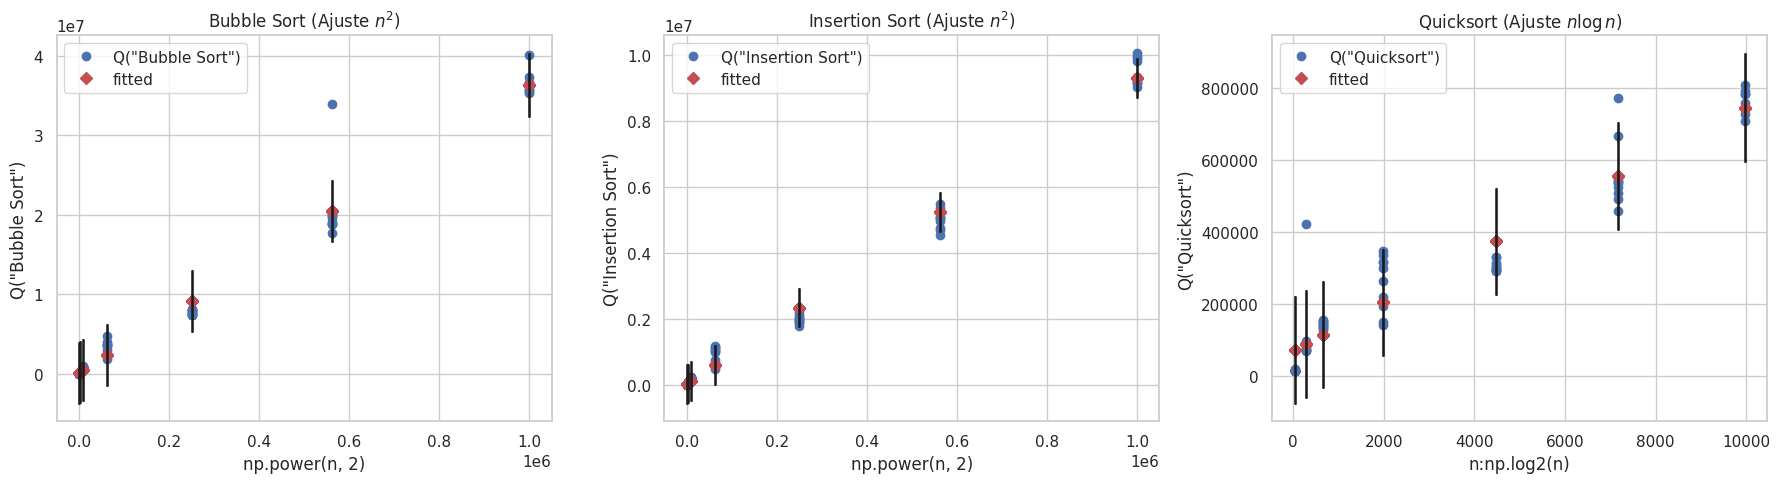

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sm.graphics.plot_fit(res_bubble, "np.power(n, 2)", ax=axes[0])
axes[0].set_title(r"Bubble Sort (Ajuste $n^2$)")

sm.graphics.plot_fit(res_insertion, "np.power(n, 2)", ax=axes[1])
axes[1].set_title(r"Insertion Sort (Ajuste $n^2$)")

sm.graphics.plot_fit(res_quick, "n:np.log2(n)", ax=axes[2])
axes[2].set_title(r"Quicksort (Ajuste $n \log n$)")

plt.tight_layout()
plt.show()